In [1]:
import numpy as np
import h5py
import glob
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import roc_curve, auc, roc_auc_score
import os

2025-04-02 16:31:28.862017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 16:31:29.281246: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 16:31:29.433627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743636689.578559 3860361 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743636689.684592 3860361 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743636690.394781 3860361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Function to calculate reconstruction MSE
def calculate_mse(model, electron_features, photon_features, vertices):
    vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
    # Prepare inputs
    inputs = {
        'electron_input': electron_features,
        'photon_input': photon_features,
        'vertex_input': vertices
    }
    
    # Get model predictions
    predictions = model.predict(inputs, batch_size=2048)
    
    # Calculate MSE for electrons
    electron_mse = np.mean(
        np.square(predictions['electron_output'] - electron_features),
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Calculate MSE for photons
    photon_mse = np.mean(
        np.square(predictions['photon_output'] - photon_features),
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Total MSE (average of electron and photon MSEs)
    total_mse = (electron_mse + photon_mse) / 2
    
    return total_mse

In [45]:
# Function to calculate reconstruction MAE
def calculate_mae(model, electron_features, photon_features, vertices):
    vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
    # Prepare inputs
    inputs = {
        'electron_input': electron_features,
        'photon_input': photon_features,
        'vertex_input': vertices
    }
    
    # Get model predictions
    predictions = model.predict(inputs, batch_size=2048)
    
    # Calculate MAE for electrons
    electron_mae = np.mean(
        np.absolute(predictions['electron_output'] - electron_features),
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Calculate MAE for photons
    photon_mae = np.mean(
        np.square(predictions['photon_output'] - photon_features),
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Total MAE (average of electron and photon MAEs)
    total_mae = (electron_mae + photon_mae) / 2
    
    return total_mae

In [3]:
def calculate_tanh_error(model, electron_features, photon_features, vertices):
    vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
    
    # Prepare inputs
    inputs = {
        'electron_input': electron_features,
        'photon_input': photon_features,
        'vertex_input': vertices
    }
    
    # Get model predictions
    predictions = model.predict(inputs, batch_size=512)
    
    # Calculate sigmoid of error for electrons
    electron_error = predictions['electron_output'] - electron_features
    electron_squared_error = np.square(electron_error)
    electron_squared_tanh_error = np.tanh(electron_squared_error)
    
    electron_mean_squared_tanh = np.mean(
        electron_squared_tanh_error,
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Calculate sigmoid of error for photons
    photon_error = predictions['photon_output'] - photon_features
    photon_tanh_error = np.tanh(photon_error)
    photon_squared_tanh_error = np.square(photon_tanh_error)
    photon_mean_squared_tanh = np.mean(
        photon_squared_tanh_error,
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Total mean of squared sigmoid of error (average of electron and photon values)
    total_mean_squared_tanh = (electron_mean_squared_tanh + photon_mean_squared_tanh) / 2
    
    return total_mean_squared_tanh

In [4]:
# Load data
#max_events = 1000000
print("Loading test data...")
test_electron_features = np.load('test_data_e.npy')#[:max_events]
test_photon_features = np.load('test_data_p.npy')#[:max_events]
test_vertices = np.load('test_data_v.npy')#[:max_events]

print("Loading signal data...")
# signal_electron_features = np.load('signal_data_e.npy')
# signal_photon_features = np.load('signal_data_p.npy')
# signal_vertices = np.load('signal_data_v.npy')
signal_electron_features = np.load('output_model_directory/signal_data_e_models.npy')
signal_photon_features = np.load('output_model_directory/signal_data_p_models.npy')
signal_vertices = np.load('output_model_directory/signal_data_v_models.npy')

Loading test data...


Loading signal data...


In [5]:
print(test_electron_features.shape)

(2421433, 4, 15)


In [6]:
def create_embedding_network(input_dim, hidden_dim, output_dim):
    """Create a deep embedding network."""
    return keras.Sequential([
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(output_dim)
    ])

class TransformerEncoderBlock(layers.Layer):
    """Transformer encoder block with multi-head attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def call(self, inputs):
        attention_output = self.attention(query=inputs, key=inputs, value=inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoderBlock(layers.Layer):
    """Transformer decoder block with multi-head self and cross attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.self_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.cross_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)
        
    def call(self, inputs, encoder_outputs):
        # Self attention
        self_attention_output = self.self_attention(
            query=inputs,
            key=inputs,
            value=inputs
        )
        self_attention_output = self.dropout1(self_attention_output)
        out1 = self.layernorm1(inputs + self_attention_output)
        
        # Cross attention with encoder outputs
        cross_attention_output = self.cross_attention(
            query=out1,
            key=encoder_outputs,
            value=encoder_outputs
        )
        cross_attention_output = self.dropout2(cross_attention_output)
        out2 = self.layernorm2(out1 + cross_attention_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.layernorm3(out2 + ffn_output)

In [7]:
electron_features_list = [
    'electron_E', 'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time',
    'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers',
    'electron_chi2', 'electron_numberDoF',  # Will need to handle ratio
    'electron_f1', 'electron_f3', 'electron_z'
]

photon_features_list = [
    'photon_E', 'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time',
    'photon_maxEcell_E',
    'photon_f1', 'photon_f3', 'photon_r1', 'photon_r2',
    'photon_etas1', 'photon_phis1', 'photon_z'
]

In [8]:
class ParticleTransformer(keras.Model):
    """Complete transformer model for particle physics data."""
    def __init__(
        self,
        max_electrons=4,
        max_photons=4,
        electron_embedding_dim=15,
        photon_embedding_dim=13,
        vertex_embedding_dim=3,
        common_embedding_dim=31,
        num_encoder_layers=4,
        num_decoder_layers=4,
        num_heads=4
    ):
        super().__init__()
        
        # Input embeddings with different dimensions
        self.electron_embedding = create_embedding_network(
            len(electron_features_list),  # electron feature dim
            electron_embedding_dim,
            common_embedding_dim
        )
        self.photon_embedding = create_embedding_network(
            len(photon_features_list),  # photon feature dim
            photon_embedding_dim,
            common_embedding_dim
        )
        self.vertex_embedding = create_embedding_network(
            3,   # vertex feature dim
            vertex_embedding_dim,
            common_embedding_dim
        )
              
        # Transformer encoder layers
        self.encoder_layers = [
            TransformerEncoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_encoder_layers)
        ]
        
        # Transformer decoder layers
        self.decoder_layers = [
            TransformerDecoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_decoder_layers)
        ]
        
        # Output projection layers
        self.electron_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(electron_features_list))  # electron features
        ])
        self.photon_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(photon_features_list))  # photon features
        ])
        
    def encode_particles(self, electron_inputs, photon_inputs, vertex_inputs):
        # Embed particles
        e_embedded = self.electron_embedding(electron_inputs)
        p_embedded = self.photon_embedding(photon_inputs)
        v_embedded = self.vertex_embedding(vertex_inputs)
        
        # Combine embeddings
        combined = tf.concat([e_embedded, p_embedded, v_embedded], axis=1)
        
        # Pass through encoder layers
        encoded = combined
        intermediates = []
        for encoder_layer in self.encoder_layers:
            encoded = encoder_layer(encoded)
            intermediates.append(encoded)
            
        return encoded, intermediates
        
    def decode_particles(self, encoded, encoder_intermediates):
        decoded = encoded
        
        # Pass through decoder layers with corresponding encoder outputs
        for decoder_layer, encoder_output in zip(self.decoder_layers, encoder_intermediates):
            decoded = decoder_layer(decoded, encoder_output)
            
        return decoded
        
    def call(self, inputs):
        # Unpack inputs
        electron_inputs = inputs['electron_input']
        photon_inputs = inputs['photon_input']
        vertex_inputs = inputs['vertex_input']
        
        # Encode
        encoded, encoder_intermediates = self.encode_particles(
            electron_inputs, photon_inputs, vertex_inputs)
        
        # Decode
        decoded = self.decode_particles(encoded, encoder_intermediates)
        
        # Split and reconstruct
        e_len = electron_inputs.shape[1]
        electron_decoded = decoded[:, :e_len]
        photon_decoded = decoded[:, e_len:-1]
        
        # Output
        return {
            'electron_output': self.electron_reconstruction(electron_decoded),
            'photon_output': self.photon_reconstruction(photon_decoded)
        }

In [9]:
class ParticleDataGenerator(keras.utils.Sequence):
    """Data generator for particle physics events."""
    def __init__(self, data, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.electron_data, self.photon_data, self.vertex_data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.vertex_data))
        self.on_epoch_end()
        
    def __len__(self):
        """Number of batches per epoch."""
        return len(self.indices) // self.batch_size
        
    def on_epoch_end(self):
        """Called at the end of every epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        """Get one batch of data."""
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Prepare batch data
        x = {
            'electron_input': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_input': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32),
            'vertex_input': tf.convert_to_tensor(self.vertex_data[batch_indices, np.newaxis, :], dtype=tf.float32)
        }
        
        y = {
            'electron_output': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_output': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32)
        }
        
        return x, y


In [10]:
# Create the model with the correct dimensions
model = ParticleTransformer(
    max_electrons=4,
    max_photons=4,
    electron_embedding_dim=15,
    photon_embedding_dim=13,
    vertex_embedding_dim=3,
    common_embedding_dim=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    num_heads=4
)


# Create model with specified input shapes
electron_input = keras.Input(shape=(4, len(electron_features_list)), name='electron_input')
photon_input = keras.Input(shape=(4, len(photon_features_list)), name='photon_input')
vertex_input = keras.Input(shape=(1, 3), name='vertex_input')

outputs = model({
    'electron_input': electron_input,
    'photon_input': photon_input,
    'vertex_input': vertex_input
})

model = keras.Model(
    inputs={
        'electron_input': electron_input,
        'photon_input': photon_input,
        'vertex_input': vertex_input
    },
    outputs=outputs
)

# Load weights
model_path = 'particle_transformer_v1.keras'
# model_path = 'model_v0.weights.h5'
print(f"Loading weights from {model_path}...")
# Try first with load_weights
model.load_weights(model_path)
print("Weights loaded successfully.")

2025-04-02 16:31:50.898929: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Loading weights from particle_transformer_v1.keras...
Weights loaded successfully.


In [16]:
print(signal_electron_features[0])

[[-6.34727109e-01 -6.34847900e-01 -2.25583820e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.90080706e-01 -2.96315813e-01 -6.34225379e-01 -6.35100411e-01
  -5.92494755e-01 -4.21631119e-01  2.48857231e-04]
 [-6.34727109e-01 -6.34847900e-01 -2.25583820e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.90080706e-01 -2.96315813e-01 -6.34225379e-01 -6.35100411e-01
  -5.92494755e-01 -4.21631119e-01  2.48857231e-04]
 [-6.34727109e-01 -6.34847900e-01 -2.25583820e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.90080706e-01 -2.96315813e-01 -6.34225379e-01 -6.35100411e-01
  -5.92494755e-01 -4.21631119e-01  2.48857231e-04]
 [-6.34727109e-01 -6.34847900e-01 -2.25583820e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.90080706e-01 -2.96315813e-01 -6.34225379e-01 -6.35100411e-01
  -5.92494755e-01 -4.21631119e-01  2.48857231e-04]]


In [ ]:
# # Calculate anomaly scores (MSE)
# print("Calculating test data anomaly scores...")
# test_scores = calculate_mse(model, test_electron_features, test_photon_features, test_vertices)

# print("Calculating signal data anomaly scores...")
# signal_scores = calculate_mse(model, signal_electron_features, signal_photon_features, signal_vertices)

# # Create labels (0 for test/background, 1 for signal)
# test_labels = np.zeros(len(test_scores))
# signal_labels = np.ones(len(signal_scores))

# # Combine scores and labels
# all_scores = np.concatenate([test_scores, signal_scores])
# all_labels = np.concatenate([test_labels, signal_labels])

# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
# roc_auc = auc(fpr, tpr)

In [11]:
# Calculate anomaly scores
print("Calculating test data anomaly scores...")
test_scores = calculate_tanh_error(model, test_electron_features, test_photon_features, test_vertices)

print("Calculating signal data anomaly scores...")
signal_scores = calculate_tanh_error(model, signal_electron_features, signal_photon_features, signal_vertices)

# Create labels (0 for test/background, 1 for signal)
test_labels = np.zeros(len(test_scores))
signal_labels = np.ones(len(signal_scores))

# Combine scores and labels
all_scores = np.concatenate([test_scores, signal_scores])
all_labels = np.concatenate([test_labels, signal_labels])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

print(f"Overall ROC AUC: {roc_auc:.6f}")

Calculating test data anomaly scores...
4730/4730 ━━━━━━━━━━━━━━━━━━━━ 309s 65ms/step
Calculating signal data anomaly scores...
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 261s 64ms/step
Overall ROC AUC: 0.908981


In [12]:
print(roc_auc)

0.8912000746405815


In [53]:
# # Calculate anomaly scores (MAE)
# print("Calculating test data anomaly scores...")
# test_scores = calculate_mae(model, test_electron_features, test_photon_features, test_vertices)

# print("Calculating signal data anomaly scores...")
# signal_scores = calculate_mae(model, signal_electron_features, signal_photon_features, signal_vertices)

# # Create labels (0 for test/background, 1 for signal)
# test_labels = np.zeros(len(test_scores))
# signal_labels = np.ones(len(signal_scores))

# # Combine scores and labels
# all_scores = np.concatenate([test_scores, signal_scores])
# all_labels = np.concatenate([test_labels, signal_labels])

# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
# roc_auc = auc(fpr, tpr)

Calculating test data anomaly scores...
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 101s 85ms/step
Calculating signal data anomaly scores...
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 84s 83ms/step


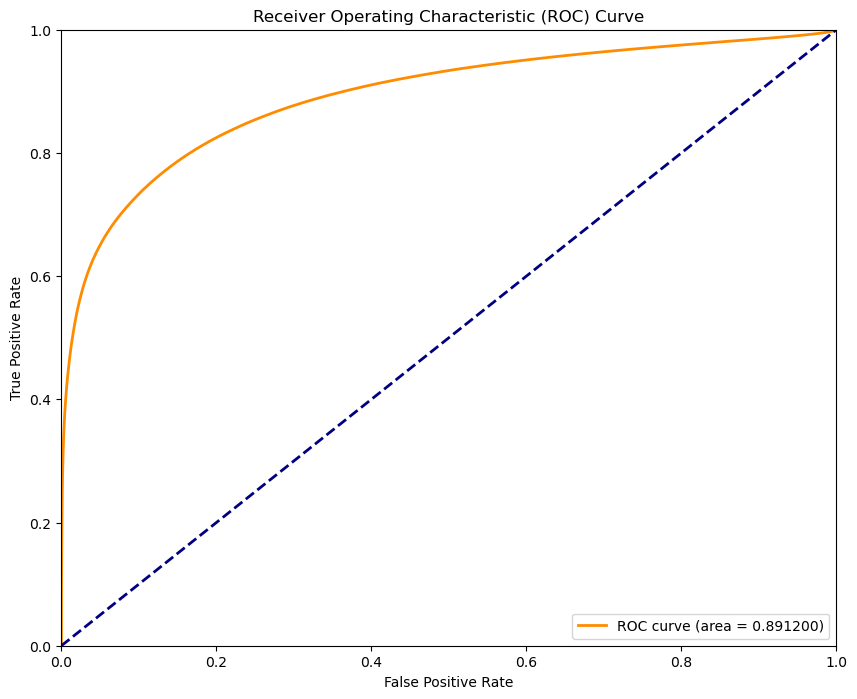

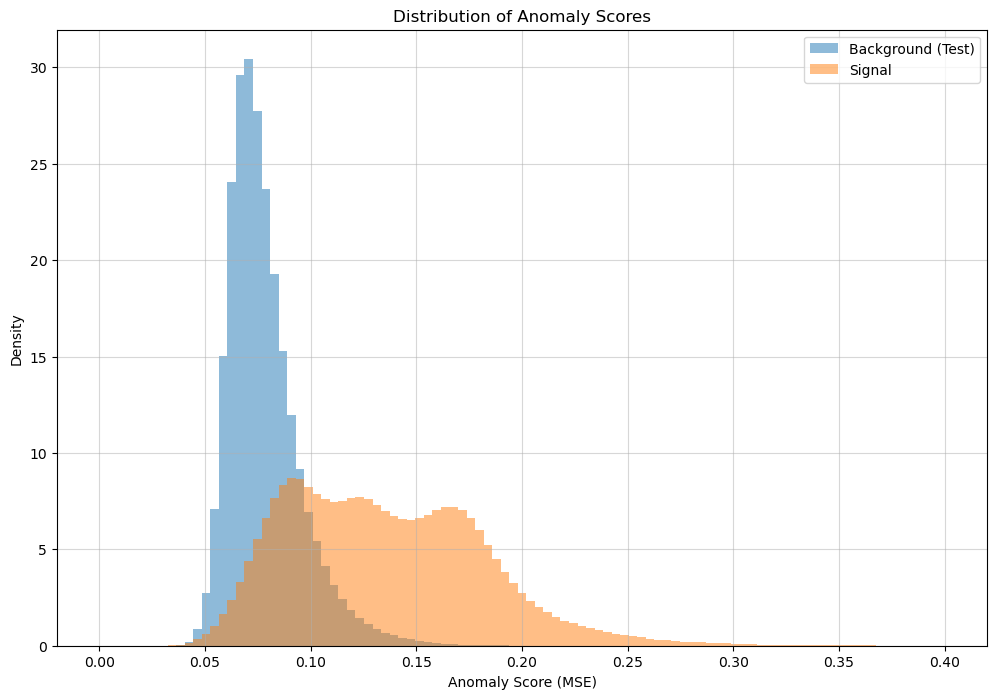

Test data: Mean MSE = 0.078088, Std = 0.017258, Max = 0.267774
Signal data: Mean MSE = 0.135425, Std = 0.046216
ROC AUC: 0.891200
Best threshold = 0.094063
At this threshold:
  True Positive Rate (TPR) = 0.785097
  False Positive Rate (FPR) = 0.148472
  Geometric Mean = 0.817638


In [11]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot histograms of anomaly scores
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 0.4, 100)

plt.hist(test_scores, bins=bins, alpha=0.5, label='Background (Test)', density=True)
plt.hist(signal_scores, bins=bins, alpha=0.5, label='Signal', density=True)
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Density')
# plt.yscale('log')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True, alpha=0.5)

# Save the histogram
plt.savefig('anomaly_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print(f"Test data: Mean MSE = {np.mean(test_scores):.6f}, Std = {np.std(test_scores):.6f}, Max = {np.max(test_scores):.6f}")
print(f"Signal data: Mean MSE = {np.mean(signal_scores):.6f}, Std = {np.std(signal_scores):.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

# Find the best threshold based on maximum geometric mean of TPR and (1-FPR)
gmeans = np.sqrt(tpr * (1-fpr))
best_idx = np.argmax(gmeans)
best_threshold = thresholds[best_idx]
best_gmean = gmeans[best_idx]

print(f"Best threshold = {best_threshold:.6f}")
print(f"At this threshold:")
print(f"  True Positive Rate (TPR) = {tpr[best_idx]:.6f}")
print(f"  False Positive Rate (FPR) = {fpr[best_idx]:.6f}")
print(f"  Geometric Mean = {best_gmean:.6f}")

In [68]:
def plot_fraction_vs_threshold(test_scores, signal_scores, thresholds=None, num_points=100):
    # If thresholds not provided, create a range of values
    if thresholds is None:
        min_score = min(np.min(test_scores), np.min(signal_scores))
        max_score = 0.175#max(np.max(test_scores), 15000)
        thresholds = np.linspace(min_score, max_score, num_points)
    
    # Calculate fractions passing each threshold
    signal_fractions = []
    background_fractions = []
    s_over_b_ratios = []
    
    for threshold in thresholds:
        signal_passing = np.sum(signal_scores > threshold)
        background_passing = np.sum(test_scores > threshold)
        
        signal_fraction = signal_passing / len(signal_scores)
        background_fraction = background_passing / len(test_scores)
        
        signal_fractions.append(signal_fraction)
        background_fractions.append(background_fraction)
        
        # Calculate S/B ratio (handle division by zero)
        s_over_b = signal_passing / (background_passing+signal_passing)
            
        s_over_b_ratios.append(s_over_b)  # Cap at 100 for plotting
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Second subplot for S/B ratio
    plt.plot(thresholds, s_over_b_ratios, 'g-')
    plt.xlabel('Threshold')
    plt.ylabel('Signal/Background Ratio')
    plt.ylim([0, 1])
    plt.title('Signal to Background Ratio vs Threshold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('threshold_fractions.png', dpi=300)
    plt.show()
    
    # Find some interesting thresholds for reporting
    sig_90_idx = np.argmin(np.abs(np.array(signal_fractions) - 0.9))
    sig_50_idx = np.argmin(np.abs(np.array(signal_fractions) - 0.5))
    sig_10_idx = np.argmin(np.abs(np.array(signal_fractions) - 0.1))
    
    print(f"At 90% signal efficiency (threshold={thresholds[sig_90_idx]:.6f}):")
    print(f"  Background pass rate: {background_fractions[sig_90_idx]:.6f}")
    print(f"  S/B ratio: {s_over_b_ratios[sig_90_idx]:.3f}")
    
    print(f"At 50% signal efficiency (threshold={thresholds[sig_50_idx]:.6f}):")
    print(f"  Background pass rate: {background_fractions[sig_50_idx]:.6f}")
    print(f"  S/B ratio: {s_over_b_ratios[sig_50_idx]:.3f}")
    
    print(f"At 10% signal efficiency (threshold={thresholds[sig_10_idx]:.6f}):")
    print(f"  Background pass rate: {background_fractions[sig_10_idx]:.6f}")
    print(f"  S/B ratio: {s_over_b_ratios[sig_10_idx]:.3f}")

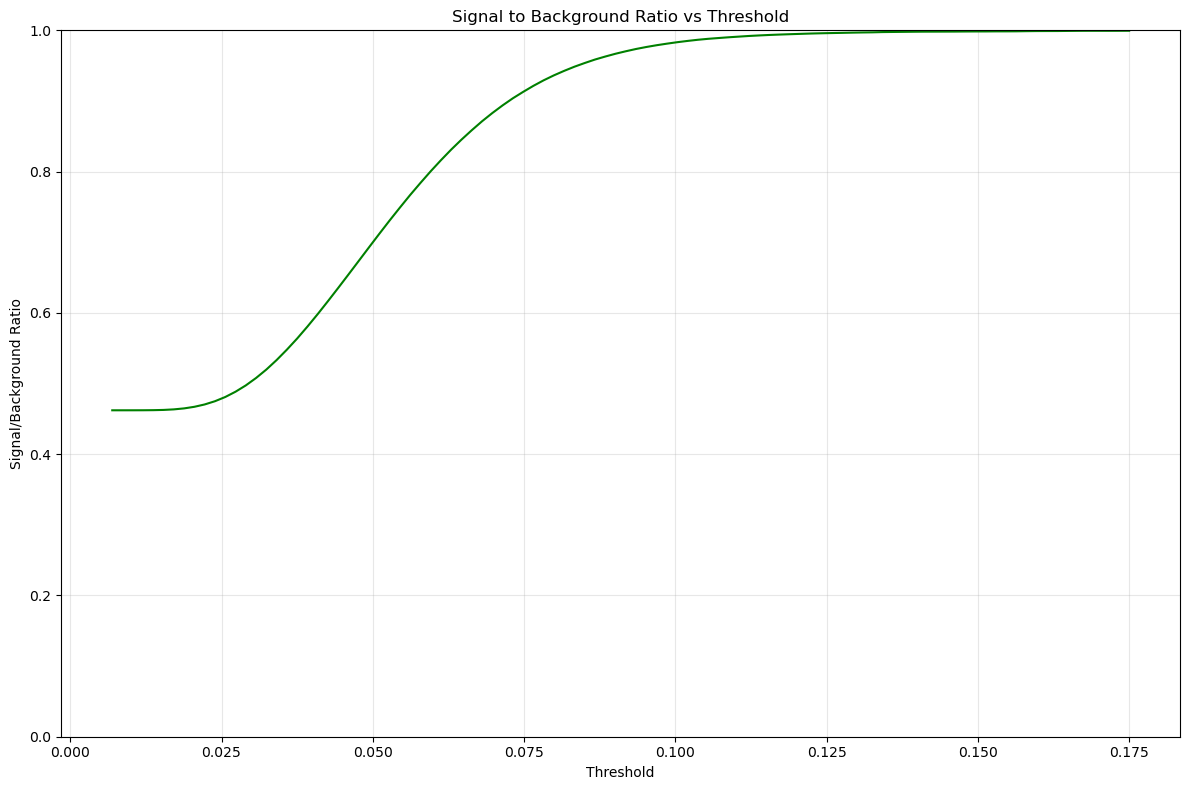

At 90% signal efficiency (threshold=0.044286):
  Background pass rate: 0.445293
  S/B ratio: 0.635
At 50% signal efficiency (threshold=0.085028):
  Background pass rate: 0.021198
  S/B ratio: 0.954
At 10% signal efficiency (threshold=0.134258):
  Background pass rate: 0.000206
  S/B ratio: 0.998


In [69]:
# Call the function with your scores
plot_fraction_vs_threshold(test_scores, signal_scores)

In [70]:
def display_highest_score_events(model, e_feats, p_feats, vertices, scores, n_events=2, dataset_name="Dataset"):
    """
    Display the highest-scoring events from a dataset.
    """
    # Find indices of highest scoring events
    top_indices = np.argsort(scores)[-n_events:][::-1]
    
    print(f"\n===== Top {n_events} highest scoring events from {dataset_name} =====")
    
    for i, idx in enumerate(top_indices):
        # Get input features for this event
        electron_input = e_feats[idx:idx+1]
        photon_input = p_feats[idx:idx+1]
        
        # Handle vertex input - reshape if necessary
        vertex_input = vertices[idx:idx+1]
        if len(vertex_input.shape) == 2:
            vertex_input = vertex_input.reshape(vertex_input.shape[0], 1, vertex_input.shape[1])
        
        # Get model prediction
        inputs = {
            'electron_input': electron_input,
            'photon_input': photon_input,
            'vertex_input': vertex_input
        }
        prediction = model.predict(inputs, verbose=0)
        
        # Print event information
        print(f"\nEvent {i+1} (index {idx}): Score = {scores[idx]:.6f}")
        
        # Print basic event properties
        if vertex_input.shape[1] == 1:
            print(f"  Vertex position: {vertex_input[0, 0]}")
        
        # Count non-zero energy particles
        n_electrons = 4
        n_photons = 4
        print(f"  Number of electrons: {n_electrons}")
        print(f"  Number of photons: {n_photons}")
        
        # Print features of all particles with comparisons
        print("\n  ELECTRONS (actual vs predicted):")
        for e_idx in range(4):
            print(f"  Electron #{e_idx+1}:")
            for feat_idx in range(min(15, electron_input.shape[2])):
                actual = electron_input[0, e_idx, feat_idx]
                pred = prediction['electron_output'][0, e_idx, feat_idx]
                diff = actual - pred
                print(f"    Feature {feat_idx}: {actual:.4f} vs {pred:.4f} (diff: {diff:.4f})")
            print("")
        
        print("\n  PHOTONS (actual vs predicted):")
        for p_idx in range(4):
            print(f"  Photon #{p_idx+1}:")
            for feat_idx in range(min(13, photon_input.shape[2])):
                actual = photon_input[0, p_idx, feat_idx]
                pred = prediction['photon_output'][0, p_idx, feat_idx]
                diff = actual - pred
                print(f"    Feature {feat_idx}: {actual:.4f} vs {pred:.4f} (diff: {diff:.4f})")
            print("")

In [71]:
# Display highest scoring signal events
signal_indices = np.where(all_labels == 1)[0]
signal_only_scores = all_scores[signal_indices]
display_highest_score_events(
    model,
    signal_electron_features,
    signal_photon_features,
    signal_vertices,
    signal_only_scores,
    n_events=5,
    dataset_name="Signal"
)



===== Top 5 highest scoring events from Signal =====

Event 1 (index 1836177): Score = 0.321724
  Vertex position: [ 7.4381313 -8.308621  -2.1994405]
  Number of electrons: 4
  Number of photons: 4

  ELECTRONS (actual vs predicted):
  Electron #1:
    Feature 0: 1.6454 vs 1.5720 (diff: 0.0734)
    Feature 1: 1.6724 vs 1.5707 (diff: 0.1017)
    Feature 2: -0.1662 vs -0.0086 (diff: -0.1576)
    Feature 3: -0.6329 vs 0.0017 (diff: -0.6346)
    Feature 4: 0.8250 vs 0.3860 (diff: 0.4390)
    Feature 5: 41.4470 vs 0.0164 (diff: 41.4306)
    Feature 6: 10.3511 vs 10.9126 (diff: -0.5614)
    Feature 7: -0.5114 vs -0.2322 (diff: -0.2792)
    Feature 8: 0.5251 vs 1.5308 (diff: -1.0057)
    Feature 9: -0.2963 vs 0.1679 (diff: -0.4642)
    Feature 10: 1.5299 vs 1.5544 (diff: -0.0245)
    Feature 11: 1.5826 vs 1.5689 (diff: 0.0137)
    Feature 12: 1.4496 vs 1.4414 (diff: 0.0082)
    Feature 13: 0.2899 vs 0.8776 (diff: -0.5877)
    Feature 14: 0.0018 vs 0.0046 (diff: -0.0028)

  Electron #2:
    F

In [72]:
# Display highest scoring background events
background_indices = np.where(all_labels == 0)[0]
background_only_scores = all_scores[background_indices]
display_highest_score_events(
    model,
    test_electron_features,
    test_photon_features,
    test_vertices,
    background_only_scores,
    n_events=3,
    dataset_name="Background"
)


===== Top 3 highest scoring events from Background =====

Event 1 (index 385257): Score = 0.206427
  Vertex position: [ 0.83112246 -0.51043886  0.46420366]
  Number of electrons: 4
  Number of photons: 4

  ELECTRONS (actual vs predicted):
  Electron #1:
    Feature 0: -0.6366 vs -0.6241 (diff: -0.0125)
    Feature 1: -0.6367 vs -0.6232 (diff: -0.0135)
    Feature 2: -0.0015 vs 0.0021 (diff: -0.0035)
    Feature 3: -0.0000 vs -0.0049 (diff: 0.0049)
    Feature 4: 0.0000 vs 0.4497 (diff: -0.4497)
    Feature 5: 0.0000 vs -0.0053 (diff: 0.0053)
    Feature 6: 0.0000 vs 0.0328 (diff: -0.0328)
    Feature 7: 0.0000 vs 0.0047 (diff: -0.0047)
    Feature 8: -0.5917 vs -0.5710 (diff: -0.0207)
    Feature 9: -0.2978 vs -0.2944 (diff: -0.0034)
    Feature 10: -0.6360 vs -0.6255 (diff: -0.0105)
    Feature 11: -0.6369 vs -0.6208 (diff: -0.0162)
    Feature 12: -0.5941 vs -0.5831 (diff: -0.0110)
    Feature 13: -0.4227 vs -0.4004 (diff: -0.0223)
    Feature 14: 0.0003 vs -0.0044 (diff: 0.0046)



In [37]:
def plot_feature_distributions(test_e_feats, test_p_feats, signal_e_feats, signal_p_feats, 
                               e_feat_indices=[7, 10], p_feat_indices=[-1]):
    """
    Plot distributions of specified electron and photon features for test and signal datasets.
    
    Parameters:
    -----------
    test_e_feats: Electron features from test/background dataset
    test_p_feats: Photon features from test/background dataset
    signal_e_feats: Electron features from signal dataset
    signal_p_feats: Photon features from signal dataset
    e_feat_indices: List of electron feature indices to plot
    p_feat_indices: List of photon feature indices to plot
    """
    n_e_features = len(e_feat_indices)
    n_p_features = len(p_feat_indices)
    n_plots = n_e_features + n_p_features
    
    # Create figure with appropriate number of subplots
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, 5*n_plots))
    if n_plots == 1:
        axes = [axes]  # Make sure axes is always a list
    
    plot_idx = 0
    
    # Plot electron feature distributions
    for feat_idx in e_feat_indices:
        ax = axes[plot_idx]
        
        # Extract non-zero values (from particles that exist)
        test_vals = []
        for event in range(test_e_feats.shape[0]):
            for particle in range(test_e_feats.shape[1]):
                if test_e_feats[event, particle, 0] > 0:  # Check if particle exists (energy > 0)
                    test_vals.append(test_e_feats[event, particle, feat_idx])
        
        signal_vals = []
        for event in range(signal_e_feats.shape[0]):
            for particle in range(signal_e_feats.shape[1]):
                if signal_e_feats[event, particle, 0] > 0:  # Check if particle exists
                    signal_vals.append(signal_e_feats[event, particle, feat_idx])
        
        # Convert to numpy arrays
        test_vals = np.array(test_vals)
        signal_vals = np.array(signal_vals)
        
        # Calculate range for bins
        min_val = min(np.min(test_vals), np.min(signal_vals))
        max_val = max(np.max(test_vals), np.max(signal_vals))
        # Handle case where min=max
        if min_val == max_val:
            min_val -= 0.5
            max_val += 0.5
            
        bins = np.linspace(min_val, max_val, 100)
        
        # Plot histograms
        ax.hist(test_vals, bins=bins, alpha=0.5, label=f'Test (n={len(test_vals)})', density=True)
        ax.hist(signal_vals, bins=bins, alpha=0.5, label=f'Signal (n={len(signal_vals)})', density=True)
        
        ax.set_xlabel(f'Electron Feature {feat_idx}')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        ax.set_title(f'Distribution of Electron Feature {feat_idx}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Plot photon feature distributions
    for feat_idx in p_feat_indices:
        ax = axes[plot_idx]
        
        # Convert negative index to positive if needed
        p_idx = feat_idx if feat_idx >= 0 else test_p_feats.shape[2] + feat_idx
        
        # Extract non-zero values (from particles that exist)
        test_vals = []
        for event in range(test_p_feats.shape[0]):
            for particle in range(test_p_feats.shape[1]):
                if test_p_feats[event, particle, 0] > 0:  # Check if particle exists
                    test_vals.append(test_p_feats[event, particle, p_idx])
        
        signal_vals = []
        for event in range(signal_p_feats.shape[0]):
            for particle in range(signal_p_feats.shape[1]):
                if signal_p_feats[event, particle, 0] > 0:  # Check if particle exists
                    signal_vals.append(signal_p_feats[event, particle, p_idx])
        
        # Convert to numpy arrays
        test_vals = np.array(test_vals)
        signal_vals = np.array(signal_vals)
        
        # Calculate range for bins
        min_val = min(np.min(test_vals), np.min(signal_vals))
        max_val = max(np.max(test_vals), np.max(signal_vals))
        # Handle case where min=max
        if min_val == max_val:
            min_val -= 0.5
            max_val += 0.5
            
        bins = np.linspace(min_val, max_val, 100)
        
        # Plot histograms
        ax.hist(test_vals, bins=bins, alpha=0.5, label=f'Test (n={len(test_vals)})', density=True)
        ax.hist(signal_vals, bins=bins, alpha=0.5, label=f'Signal (n={len(signal_vals)})', density=True)
        
        ax.set_xlabel(f'Photon Feature {p_idx}')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        ax.set_title(f'Distribution of Photon Feature {p_idx}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=300)
    plt.show()

In [ ]:
# plot_feature_distributions(
#     test_electron_features,
#     test_photon_features,
#     signal_electron_features,
#     signal_photon_features,
#     e_feat_indices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
#     p_feat_indices=[0,1,2,3,4,5,6,7,8,9,10,11,12]
# )